# Rebalancing Frequency

Group 5, Math Methods in Financial Economics  

In order to determine the appropriate frequency for rebalancing a portfolio to correct for drift, we use past porfolio performance and Monte Carlo simulation to consider different rebalancing timesteps.

## Examine Mutual Fund Data

Import fund data from Yahoo!Finance, clean, and plot.

In [1]:
#import data
import pandas as pd
import pandas_datareader.data as web
import datetime

start = datetime.datetime(1999, 7, 1)
end = datetime.datetime(2016, 7, 1)

VEIEX = web.DataReader("VEIEX", 'yahoo', start, end) #emerging markets
VGSIX = web.DataReader("VGSIX", 'yahoo', start, end) #real estate investment trusts
VISVX = web.DataReader("VISVX", 'yahoo', start, end) #small cap value
VIVAX = web.DataReader("VIVAX", 'yahoo', start, end) #value index (large)
VIMSX = web.DataReader("VIMSX", 'yahoo', start, end) #mid cap
VIGRX = web.DataReader("VIGRX", 'yahoo', start, end) #growth index (large)
VISGX = web.DataReader("VISGX", 'yahoo', start, end) #small cap growth
VEURX = web.DataReader("VEURX", 'yahoo', start, end) #European
VPACX = web.DataReader("VPACX", 'yahoo', start, end) #Pacific
VBISX = web.DataReader("VBISX", 'yahoo', start, end) #short term government bonds

In [2]:
#concatenate data
funds = [VEIEX, VGSIX, VISVX, VIVAX, VIMSX, VIGRX, VEURX, VPACX, VBISX]
fundnames = ["VEIEX", "VGSIX", "VISVX", "VIVAX", "VIMSX", "VIGRX", "VEURX", "VPACX", "VBISX"]

for k in range(0,len(fundnames)):
    funds[k] = funds[k].drop(["Open", "High", "Low", "Close", "Volume"],1)
    funds[k] = funds[k].rename(index=str, columns={"Adj Close":fundnames[k]})

history = pd.concat(funds, axis=1)
history.index = pd.to_datetime(history.index)

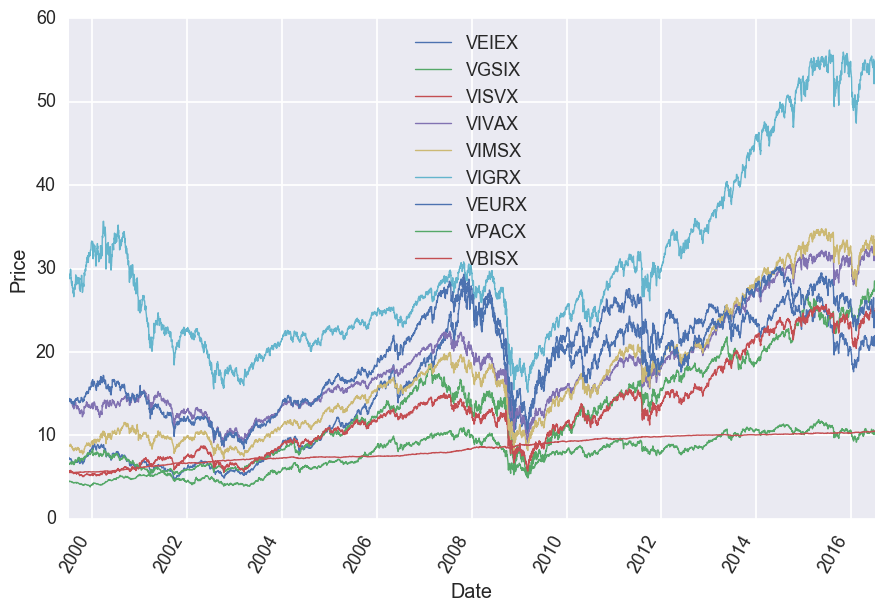

In [3]:
#plot data
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

sns.set_context("talk", rc={"lines.linewidth": 1})
history.plot(rot=60)
plt.xlabel('Date')
plt.ylabel('Price')

## Calculate Returns and Volatility for Each Stock

In [1]:
#This section is adapted from Gouthaman Balaraman
import numpy as np

fundinfo = np.zeros((len(history.columns), 2))

for k in range(0,len(history.columns)):
    df=history[fundnames[k]]

    # create a time-series of monthly data points
    rsmp = df.resample('M').last()

    # compute returns
    rts = rsmp/rsmp.shift(1) - 1
    rts = rts.dropna()
    covmat = np.cov(rts)

    # 5 - year volatility
    volatility = np.sqrt(covmat)

    # annualize the numbers
    prd = 12. # used monthly returns; 12 periods to annualize
    volatility = volatility*np.sqrt(prd)

    av_ret = rts.mean()
    
    fundinfo[k,0] = av_ret
    fundinfo[k,1] = volatility
    
fundstats = pd.DataFrame({'avg yr return' : fundinfo[:,0], '5 yr volatility' : fundinfo[:,1]}, index = [fundnames] )

NameError: name 'history' is not defined

## Portfolio Return Goal

This project assumes a hypothetical investor as a college age student who is just entering the professional workforce and plans to save 10% of income in an investment portfolio each year. To simplify calculations, we will assume this results in $6,000 invested every year.  

At the end of his/her 40 year work life, this investor would like to have stored $1.5 million for retirement.  

Portfolios are determined by setting a return goal of $\mu$ and minimizing the volatility $\sigma$. In order to determine $\mu$, we will use these starting points in a simple future value calculation.

In [5]:
goal = 1500000
rhi = 0.10
rlo = 0.0000001
gap = 1500000

#implement the bisection method to determine the proper r, assuming continuous compounding and biweekly investment
while abs(gap) > 0.001:
    r = (rhi + rlo)/2    
    j = 0
    P = 6000
    while j<40*26:
        j += 1
        P = P*np.exp(r*1/26)
        P = P + 6000/26
    gap = goal - P
    if gap<0:
        rhi = r
    elif gap>0:
        rlo = r
print('mu = {0:.4f}'.format(r))

mu = 0.0719


## Rebalancing Frequency


### Historical Performance

Use past stock data to compare different rebalancing timesteps: minute, hour, day, month, year.

In [6]:
# dummy stock/bond splits
ksi = 0.8
kbi = 1-ksi

kmat = np.zeros((len(history.index),(len(fundnames))))
kinit = np.zeros(len(fundnames))
kinit[len(fundnames)-1] = kbi
kinit[0] = 0.35
kinit[1] = 0.1
kinit[2] = 0.1
kinit[4] = 0.1
kinit[3] = 0.15

#initialize wealth array
W = np.zeros((len(history.index),7))
vol = np.zeros((len(history.index),7))

for j in [0,1,2,3, 4, 5, 6]:
    i = 0
    timebase = True
    driftbase = False
    if j==0:
        a = history.resample('D').first() #daily rebalance
    elif j==1:
        a = history.resample('MS').first() #monthly rebalance
    elif j==2:
        a = history.resample('AS').first() #yearly rebalance
    elif j==3:
        timebase = False
    elif j==4:
        timebase = False
        driftbase = True
        driftpoint = 0.01
    elif j==5:
        timebase = False
        driftbase = True
        driftpoint = 0.03
    elif j==6:
        timebase = False
        driftbase = True
        driftpoint = 0.05
   
    #initial number of shares of each stock
    W_init = 1000 #dollars
    delta = np.divide(kinit*W_init,history.iloc[0].values)
    for k in range(0,len(kmat)):
        W_ind = np.multiply(delta,history.iloc[k].values)
        W[k,j] = W_ind.sum()
        kmat[k,:] = np.multiply(history.iloc[k], delta/W[k,j])
        
        period = pd.date_range(history.iloc[k].name - datetime.timedelta(days=30),history.iloc[k].name)
        varperiod = history.loc[period]
        varperiod = varperiod.dropna()
        covmat = varperiod.cov()
        variance = np.dot(np.dot(kmat[k,:].T,covmat.values),kmat[k,:])
        vol[k,j] = np.sqrt(variance)
        
        drift = np.divide(kinit,kmat[k])
        drift = abs(drift[~np.isnan(drift)])-1
    
        if timebase == True and i<=len(a.index)-1 and (history.index[k].year*10000000 + history.index[k].month*1000 + history.index[k].day) >= (a.index[i].year*10000000 + a.index[i].month*1000 + a.index[i].day):
            delta = np.divide(kinit*W[k,j], history.iloc[k])
            i += 1
        
        if driftbase == True and np.amax(drift) >= driftpoint:
            delta = np.divide(kinit*W[k,j], history.iloc[k])

C:\Users\bjr21\Anaconda3\lib\site-packages\numpy\lib\function_base.py:2487: RuntimeWarning: Degrees of freedom <= 0 for slice
  warnings.warn("Degrees of freedom <= 0 for slice", RuntimeWarning)
C:\Users\bjr21\Anaconda3\lib\site-packages\numpy\lib\function_base.py:2496: RuntimeWarning: divide by zero encountered in double_scalars
  c *= 1. / np.float64(fact)
C:\Users\bjr21\Anaconda3\lib\site-packages\numpy\lib\function_base.py:2496: RuntimeWarning: invalid value encountered in multiply
  c *= 1. / np.float64(fact)
C:\Users\bjr21\Anaconda3\lib\site-packages\ipykernel\__main__.py:58: RuntimeWarning: invalid value encountered in true_divide


In [7]:
#Calculate return and volatility
Wdf = pd.DataFrame(W, index=history.index)

for k in range(0,len(Wdf.columns)):

    # create a time-series of monthly data points
    rsmp = Wdf.resample('M').last()

    # compute returns
    rts = rsmp/rsmp.shift(1) - 1
    rts = rts.dropna()    
    av_ret = rts.mean()

Daily Rebalancing: $3483.98 
Monthly Rebalancing: $3425.88 
Yearly Rebalancing: $3577.20 
No Rebalancing: $3245.15 
1% Drift: $3490.38 
3% Drift: $3462.09 
5% Drift: $3502.17


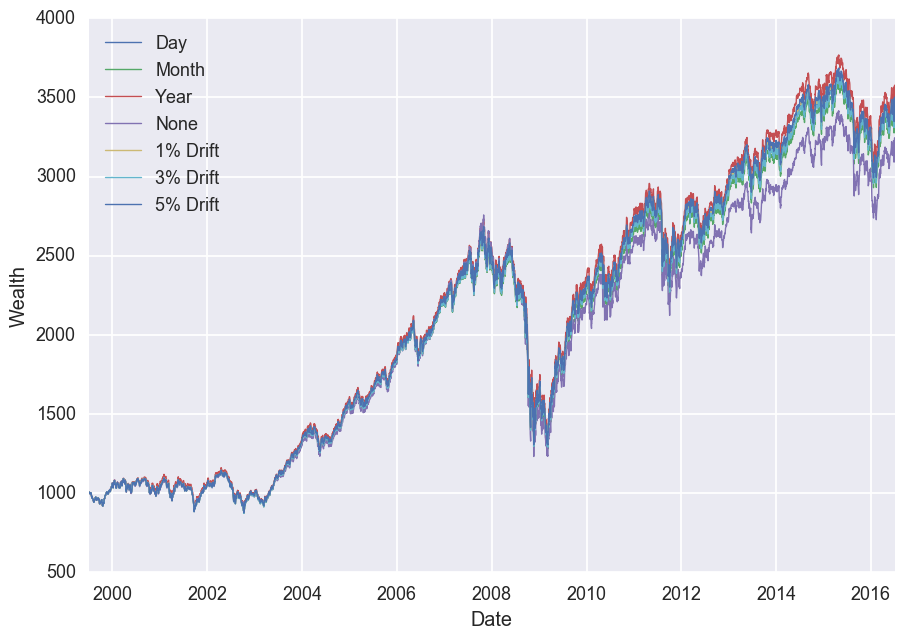

In [8]:
#print results: Wealth
plt.figure(1)
plt.plot(history.index,W)
plt.xlabel('Date')
plt.ylabel('Wealth')
plt.legend(['Day', 'Month', 'Year','None', '1% Drift', '3% Drift', '5% Drift'], loc = 0)
print('Daily Rebalancing: ${0:.2f} \nMonthly Rebalancing: ${1:.2f} \nYearly Rebalancing: ${2:.2f} \nNo Rebalancing: ${3:.2f} \n1% Drift: ${4:.2f} \n3% Drift: ${5:.2f} \n5% Drift: ${6:.2f}'.
      format(W[len(W)-1,0], W[len(W)-1,1], W[len(W)-1,2], W[len(W)-1,3], W[len(W)-1,4], W[len(W)-1,5], W[len(W)-1,6]))

Average Return 
Daily Rebalancing: 0.0072% 
Monthly Rebalancing: 0.0071% 
Yearly Rebalancing: 0.0073% 
No Rebalancing: 0.0069% 
1% Drift: 0.0072% 
3% Drift: 0.0071% 
5% Drift: 0.0072%


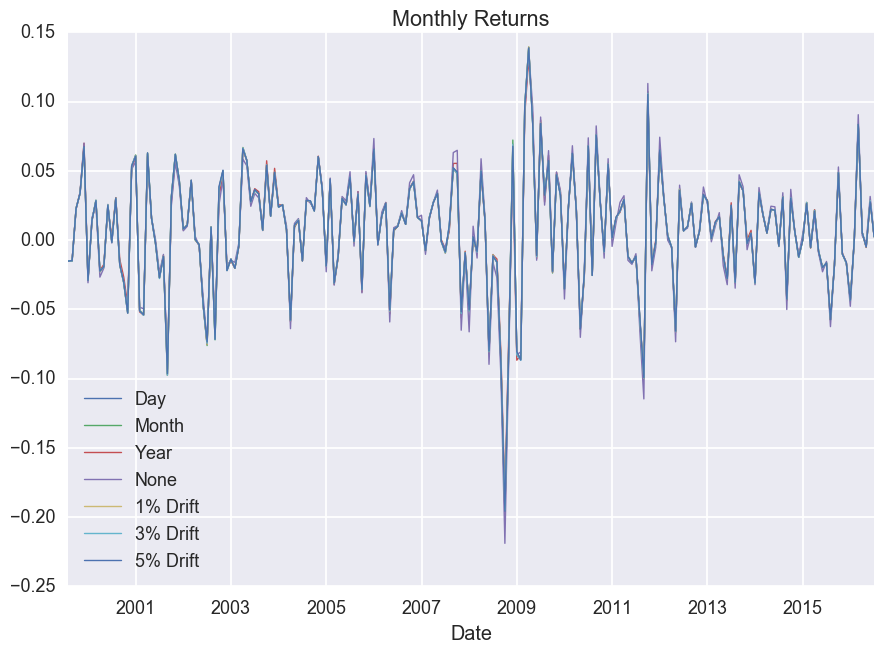

In [9]:
#print results: returns
print('Average Return \nDaily Rebalancing: {0:.4f}% \nMonthly Rebalancing: {1:.4f}% \nYearly Rebalancing: {2:.4f}% \nNo Rebalancing: {3:.4f}% \n1% Drift: {4:.4f}% \n3% Drift: {5:.4f}% \n5% Drift: {6:.4f}%'.
      format(av_ret[0], av_ret[1], av_ret[2],av_ret[3], av_ret[4], av_ret[5], av_ret[6]))
rts.plot()
plt.title('Monthly Returns')
plt.legend(['Day', 'Month', 'Year','None', '1% Drift', '3% Drift', '5% Drift'], loc = 0)
#plt.axhline(y=0.07/12, color='k', linestyle='-') #compare to a target annual return of 7%

Average Volatility 
Daily Rebalancing: 0.2455% 
Monthly Rebalancing: 0.2447% 
Yearly Rebalancing: 0.2433% 
No Rebalancing: 0.2655% 
1% Drift: 0.2455% 
3% Drift: 0.2454% 
5% Drift: 0.2456%


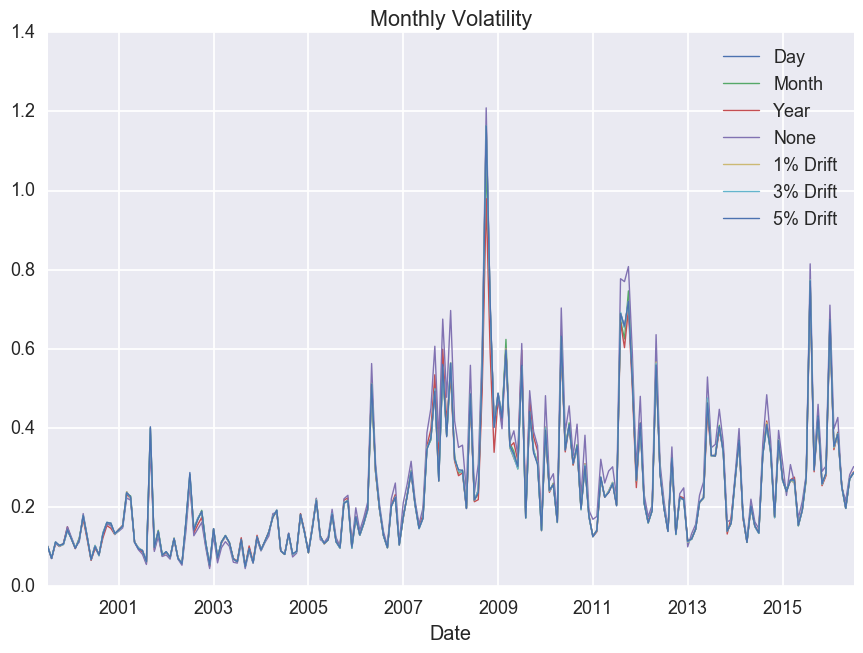

In [10]:
#print results: volatility
voldf = pd.DataFrame(vol, index=history.index)
voldf.dropna()
voldf_rsmp = voldf.resample('M').last()
voldf_rsmp
av_vol = voldf.mean()

print('Average Volatility \nDaily Rebalancing: {0:.4f}% \nMonthly Rebalancing: {1:.4f}% \nYearly Rebalancing: {2:.4f}% \nNo Rebalancing: {3:.4f}% \n1% Drift: {4:.4f}% \n3% Drift: {5:.4f}% \n5% Drift: {6:.4f}%'.
      format(av_vol[0], av_vol[1], av_vol[2],av_vol[3], av_vol[4], av_vol[5], av_vol[6]))
voldf_rsmp.plot()
plt.title('Monthly Volatility')
plt.legend(['Day', 'Month', 'Year','None', '1% Drift', '3% Drift', '5% Drift'], loc = 0)
#plt.axhline(y=0.07/12, color='k', linestyle='-') #compare to a target annual return of 7%

### Future Performance (Monte Carlo)

Use Monte Carlo process to estimate future performance of different rebalancing timesteps: minute, hour, day, month, year.

In [11]:
# DO NOT RUN AGAIN
#gbm function was adapted from Jeffrey Kantor's SimPy example (see resources) 
import simpy
import random

# geometric brownian motion
def gbm(env,name,tick,P,r,sigma):
    #P is current stock price, r is expected return, sigma is volatility
    t = end;
    while True:
        Plog.append(P)
        tlog.append(t)
        yield env.timeout(tick)
        P = P*np.exp((r-0.5*sigma**2)*tick)*np.exp(sigma*np.sqrt(tick)*random.normalvariate(0,1))
        if P<0:
            P=0
        t += datetime.timedelta(days=1)
        
# create the simulation environment
event_length = 40 #years
event_converter = 14600 #40 years converted to days

#run through simulation once to give tlog for prepping the panel
env = simpy.Environment()
name = fundstats.index[k]
env.process(gbm(env, name, event_length/event_converter, history[name][end], fundstats['avg yr return'][name], fundstats['5 yr volatility'][name]))

# run the simulation for a fixed period of time   
Plog = []
tlog = []
env.run(until=event_length)

# run the simulation multiple times, as indicated by niter
niter = 100
Psim = np.zeros((niter,int(event_converter), len(fundstats)))
Psim = pd.Panel(Psim)
Psim = Psim.reindex_axis(tlog, axis = 'major_axis')

for n in range(0,niter):
    Pstore = np.zeros((int(event_converter), len(fundstats)))

    for k in range(0,len(fundstats)):
        env = simpy.Environment()
        name = fundstats.index[k]
        env.process(gbm(env, name, event_length/event_converter, history[name][end], fundstats['avg yr return'][name], fundstats['5 yr volatility'][name]))

        # run the simulation for a fixed period of time   
        Plog = []
        tlog = []
        env.run(until=event_length)
        Pstore[:,k] = Plog
    Pstore = pd.DataFrame(Pstore, index = tlog)
    Psim[n] = Pstore

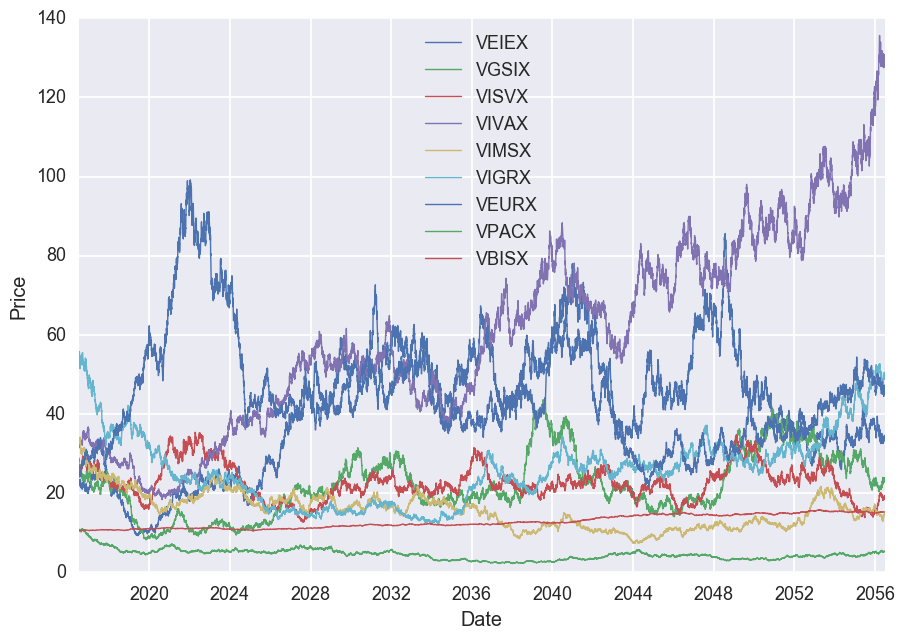

In [12]:
#plot sample stock market performance
plt.plot(tlog,Pstore)
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend(fundnames, loc=0)
sns.set_context("talk", rc={"lines.linewidth": 0.75})

In [13]:
#DO NOT RUN AGAIN
#initialize wealth array
Wsim = np.zeros((niter,int(event_converter), 7))
Wsim = pd.Panel(Wsim)
Wsim = Wsim.reindex_axis(tlog, axis = 'major_axis')

volsim = np.zeros((niter,int(event_converter), 7))
volsim = pd.Panel(volsim)
volsim = volsim.reindex_axis(tlog, axis = 'major_axis')

for n in range(0,niter):
    simslice = Psim[n]

    W = np.zeros((Psim.shape[1],7))
    vol = np.zeros((Psim.shape[1],7))
    kmat = np.zeros((Psim.shape[1],(len(fundnames))))

    for j in [0,1,2,3, 4, 5, 6]:
        i = 0
        timebase = True
        driftbase = False
        if j==0:
            a = simslice.resample('D').first() #daily rebalance
        elif j==1:
            a = simslice.resample('MS').first() #monthly rebalance
        elif j==2:
            a = simslice.resample('AS').first() #yearly rebalance
        elif j==3:
            timebase = False
        elif j==4:
            timebase = False
            driftbase = True
            driftpoint = 0.01
        elif j==5:
            timebase = False
            driftbase = True
            driftpoint = 0.03
        elif j==6:
            timebase = False
            driftbase = True
            driftpoint = 0.05
   
        #initial number of shares of each stock
        W_init = 1000 #dollars
        delta = np.divide(kinit*W_init,simslice.iloc[0].values)
        for k in range(0,len(kmat)):
            W_ind = np.multiply(delta,simslice.iloc[k].values)
            W[k,j] = W_ind.sum()
            kmat[k,:] = np.multiply(simslice.iloc[k], delta/W[k,j])
        
            period = pd.date_range(simslice.iloc[k].name - datetime.timedelta(days=30),simslice.iloc[k].name)
            varperiod = simslice.loc[period]
            varperiod = varperiod.dropna()
            covmat = varperiod.cov()
            variance = np.dot(np.dot(kmat[k,:].T,covmat.values),kmat[k,:])
            vol[k,j] = np.sqrt(variance)
        
            drift = np.divide(kinit,kmat[k])
            drift = abs(drift[~np.isnan(drift)])-1
    
            if timebase == True and i<=len(a.index)-1 and (simslice.index[k].year*10000000 + simslice.index[k].month*1000 + simslice.index[k].day) >= (a.index[i].year*10000000 + a.index[i].month*1000 + a.index[i].day):
                delta = np.divide(kinit*W[k,j], simslice.iloc[k])
                i += 1
        
            if driftbase == True and np.amax(drift) >= driftpoint:
                delta = np.divide(kinit*W[k,j], simslice.iloc[k])
    
    Wstore = pd.DataFrame(W, index = simslice.index)
    Wsim[n] = Wstore
    volstore = pd.DataFrame(vol, index = simslice.index)
    volsim[n] = volstore

C:\Users\bjr21\Anaconda3\lib\site-packages\numpy\lib\function_base.py:2487: RuntimeWarning: Degrees of freedom <= 0 for slice
  warnings.warn("Degrees of freedom <= 0 for slice", RuntimeWarning)
C:\Users\bjr21\Anaconda3\lib\site-packages\numpy\lib\function_base.py:2496: RuntimeWarning: divide by zero encountered in double_scalars
  c *= 1. / np.float64(fact)
C:\Users\bjr21\Anaconda3\lib\site-packages\numpy\lib\function_base.py:2496: RuntimeWarning: invalid value encountered in multiply
  c *= 1. / np.float64(fact)
C:\Users\bjr21\Anaconda3\lib\site-packages\ipykernel\__main__.py:57: RuntimeWarning: invalid value encountered in true_divide


In [23]:
#run only if the sim was run above
#pickle the simulation
Psim.to_pickle('Psim.pkl')
Wsim.to_pickle('Wsim.pkl')
volsim.to_pickle('volsim.pkl')

In [6]:
#use to import past simulation instead of running again
import os

mydir = os.getcwd()
Wsim = pd.read_pickle(os.path.join(mydir,'Wsim.pkl'))
Psim = pd.read_pickle(os.path.join(mydir,'Psim.pkl'))
volsim = pd.read_pickle(os.path.join(mydir,'volsim.pkl'))

In [9]:
#finds the average of the 100 simulations for each timestep
from scipy import stats
Wavg = Wsim.mean(axis=0)
Wmed = Wsim.median(axis=0)
Wstd = Wsim.std(axis=0)
Wstdf = Wstd.iloc[len(Wstd.index)-1]
Wstdf = Wstdf.values
tval = stats.norm.ppf(1-(1-0.95)/2) #calculated 2-tailed critical t value
Wstdf = Wstdf*tval

Median Wealth after 40 Years 
Daily Rebalancing: $1076.38 
Monthly Rebalancing: $1075.79 
Yearly Rebalancing: $1094.03 
No Rebalancing: $1090.07 
1% Drift: $1075.48 
3% Drift: $1071.98 
5% Drift: $1069.95


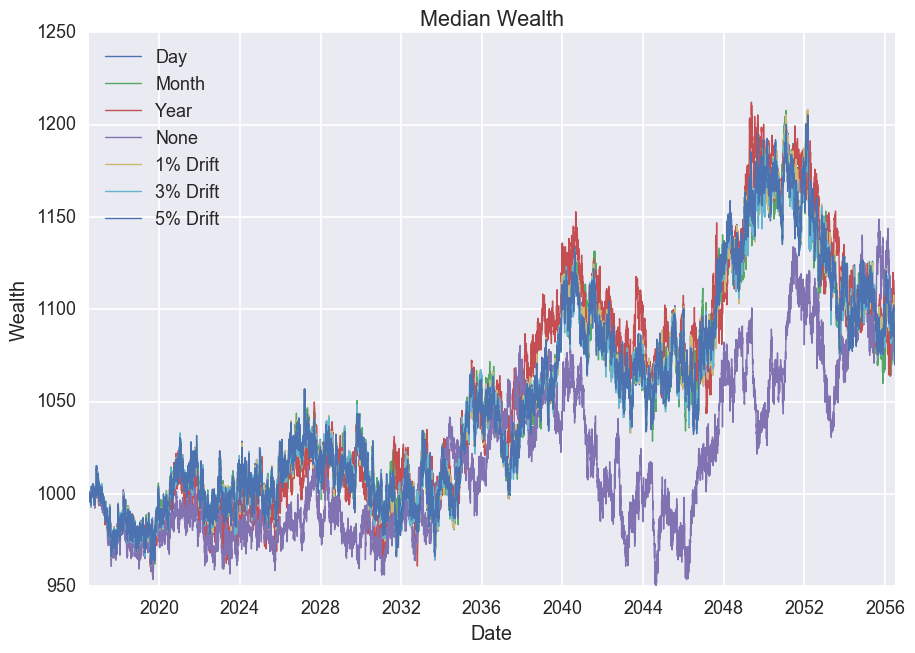

In [10]:
#print results: Wealth (median)
plt.figure(1)
plt.plot(Wmed.index,Wmed.values)
plt.xlabel('Date')
plt.ylabel('Wealth')
plt.title('Median Wealth')
plt.legend(['Day', 'Month', 'Year','None', '1% Drift', '3% Drift', '5% Drift'], loc = 0)
print('Median Wealth after 40 Years \nDaily Rebalancing: ${0:.2f} \nMonthly Rebalancing: ${1:.2f} \nYearly Rebalancing: ${2:.2f} \nNo Rebalancing: ${3:.2f} \n1% Drift: ${4:.2f} \n3% Drift: ${5:.2f} \n5% Drift: ${6:.2f}'.
      format(Wmed.iloc[len(Wmed.index)-1][0], Wmed.iloc[len(Wmed.index)-1][1], Wmed.iloc[len(Wmed.index)-1][2], Wmed.iloc[len(Wmed.index)-1][3], Wmed.iloc[len(Wmed.index)-1][4], Wmed.iloc[len(Wmed.index)-1][5], Wmed.iloc[len(Wmed.index)-1][6]))

Mean Wealth[95% confidence interval] 
Daily Rebalancing: $1245.88 +/- 1302.83 
Monthly Rebalancing: $1244.45 +/- 1298.77 
Yearly Rebalancing: $1248.69 +/- 1364.44 
No Rebalancing: $1193.46 +/- 1218.27 
1% Drift: $1245.36 +/- 1300.39 
3% Drift: $1244.20 +/- 1296.80 
5% Drift: $1246.94 +/- 1308.42


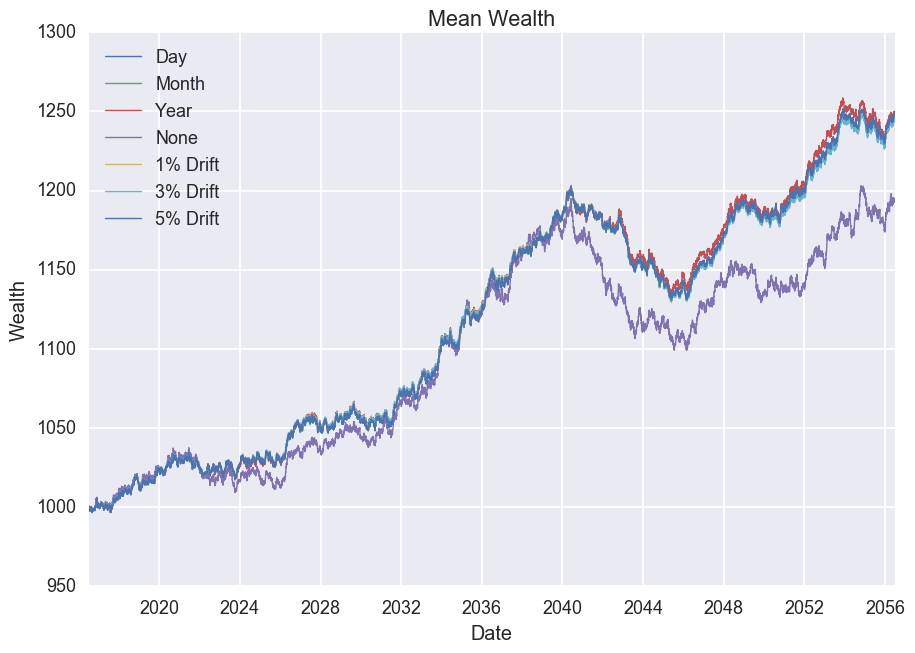

In [11]:
#print results: Wealth (mean)
plt.figure(1)
plt.plot(Wavg.index,Wavg.values)
plt.xlabel('Date')
plt.ylabel('Wealth')
plt.title('Mean Wealth')
plt.legend(['Day', 'Month', 'Year','None', '1% Drift', '3% Drift', '5% Drift'], loc = 0)
print('Mean Wealth[95% confidence interval] \nDaily Rebalancing: ${0:.2f} +/- {7:.2f} \nMonthly Rebalancing: ${1:.2f} +/- {8:.2f} \nYearly Rebalancing: ${2:.2f} +/- {9:.2f} \nNo Rebalancing: ${3:.2f} +/- {10:.2f} \n1% Drift: ${4:.2f} +/- {11:.2f} \n3% Drift: ${5:.2f} +/- {12:.2f} \n5% Drift: ${6:.2f} +/- {13:.2f}'.
      format(Wavg.iloc[len(Wavg.index)-1][0], Wavg.iloc[len(Wavg.index)-1][1], Wavg.iloc[len(Wavg.index)-1][2], Wavg.iloc[len(Wavg.index)-1][3], Wavg.iloc[len(Wavg.index)-1][4], Wavg.iloc[len(Wavg.index)-1][5], Wavg.iloc[len(Wavg.index)-1][6],Wstdf[0],Wstdf[1],Wstdf[2],Wstdf[3],Wstdf[4],Wstdf[5],Wstdf[6]))

In [12]:
for k in range(0,len(Wavg.columns)):

    # create a time-series of monthly data points
    rsmp = Wavg.resample('M').last()

    # compute returns
    rts = rsmp/rsmp.shift(1) - 1
    rts = rts.dropna()    
    av_ret = rts.mean()

Average Return 
Daily Rebalancing: 0.000465% 
Monthly Rebalancing: 0.000462% 
Yearly Rebalancing: 0.000470% 
No Rebalancing: 0.000377% 
1% Drift: 0.000464% 
3% Drift: 0.000462% 
5% Drift: 0.000467%


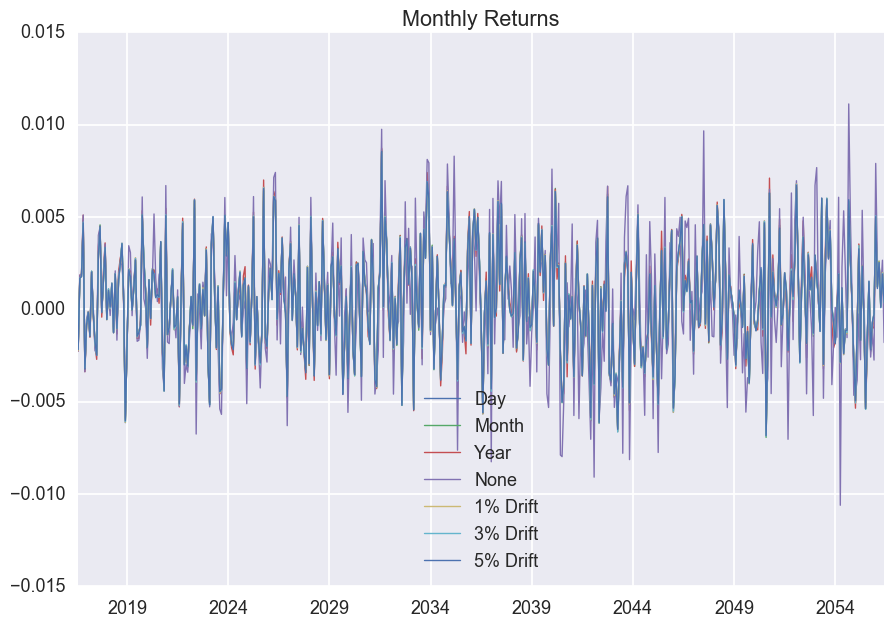

In [13]:
#print results: returns
print('Average Return \nDaily Rebalancing: {0:.6f}% \nMonthly Rebalancing: {1:.6f}% \nYearly Rebalancing: {2:.6f}% \nNo Rebalancing: {3:.6f}% \n1% Drift: {4:.6f}% \n3% Drift: {5:.6f}% \n5% Drift: {6:.6f}%'.
      format(av_ret[0], av_ret[1], av_ret[2],av_ret[3], av_ret[4], av_ret[5], av_ret[6]))
rts.plot()
plt.title('Monthly Returns')
plt.legend(['Day', 'Month', 'Year','None', '1% Drift', '3% Drift', '5% Drift'], loc = 0)

Average Volatility 
Daily Rebalancing: 0.3040% +/- 0.6582 
Monthly Rebalancing: 0.3046% +/- 0.6606 
Yearly Rebalancing: 0.3120% +/- 0.6862 
No Rebalancing: 0.6663% +/- 2.9431 
1% Drift: 0.3040% +/- 0.6587 
3% Drift: 0.3041% +/- 0.6630 
5% Drift: 0.3044% +/- 0.6697


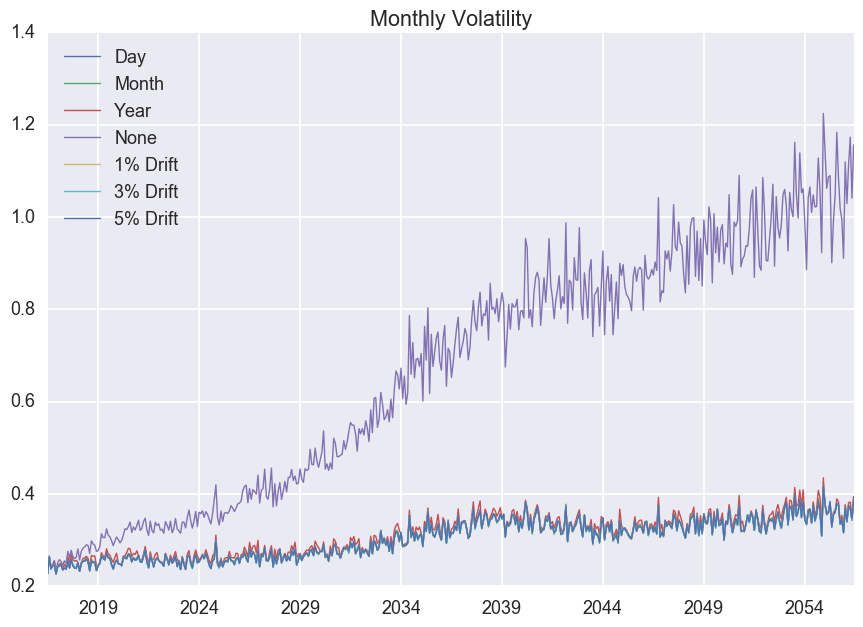

In [14]:
volavg = volsim.mean(axis=0)
volstd = volsim.std(axis=0)
volstdf = volstd.iloc[len(volstd.index)-1]
volstdf = volstdf.values
tval = stats.norm.ppf(1-(1-0.95)/2) #calculated 2-tailed critical t value
volstdf = volstdf*tval

#print results: volatility
volavg_rsmp = volavg.resample('M').last()
av_vol = volavg.mean()

print('Average Volatility \nDaily Rebalancing: {0:.4f}% +/- {7:.4f} \nMonthly Rebalancing: {1:.4f}% +/- {8:.4f} \nYearly Rebalancing: {2:.4f}% +/- {9:.4f} \nNo Rebalancing: {3:.4f}% +/- {10:.4f} \n1% Drift: {4:.4f}% +/- {11:.4f} \n3% Drift: {5:.4f}% +/- {12:.4f} \n5% Drift: {6:.4f}% +/- {13:.4f}'.
      format(av_vol[0], av_vol[1], av_vol[2],av_vol[3], av_vol[4], av_vol[5], av_vol[6], volstdf[0], volstdf[1], volstdf[2],volstdf[3],volstdf[4],volstdf[5],volstdf[6]))
volavg_rsmp.plot()
plt.title('Monthly Volatility')
plt.legend(['Day', 'Month', 'Year','None', '1% Drift', '3% Drift', '5% Drift'], loc = 0)
#plt.axhline(y=0.07/12, color='k', linestyle='-') #compare to a target annual return of 7%

## Long-Term Investor Model

For a real-life long-term investor, risk preferences change over time. While this should not modify the results found above, it is an interesting exercise to calculate what happens in a simulation that replicates this. The stock/bond split used here comes from a Vanguard "life cycle" fund found [here](https://www.fool.com/retirement/general/2015/02/06/asset-allocation-by-age-what-investments-should-yo.aspx).

In [42]:
#added in because they belong to sections above that take significant space to run
niter=100
event_converter = 14600 #40 years converted to days

Wsim = np.zeros((niter,int(event_converter), 7))
Wsim = pd.Panel(Wsim)
Wsim = Wsim.reindex_axis(Psim[0].index, axis = 'major_axis')

volsim = np.zeros((niter,int(event_converter), 7))
volsim = pd.Panel(volsim)
volsim = volsim.reindex_axis(Psim[0].index, axis = 'major_axis')

for n in range(0,niter):
    simslice = Psim[n]

    W = np.zeros((Psim.shape[1],7))
    vol = np.zeros((Psim.shape[1],7))
    kmat = np.zeros((Psim.shape[1],(len(fundnames))))

    for j in [0,1,2,3, 4, 5, 6]:
        i = 0
        timebase = True
        driftbase = False
        if j==0:
            a = simslice.resample('D').first() #daily rebalance
        elif j==1:
            a = simslice.resample('MS').first() #monthly rebalance
        elif j==2:
            a = simslice.resample('AS').first() #yearly rebalance
        elif j==3:
            timebase = False
        elif j==4:
            timebase = False
            driftbase = True
            driftpoint = 0.01
        elif j==5:
            timebase = False
            driftbase = True
            driftpoint = 0.03
        elif j==6:
            timebase = False
            driftbase = True
            driftpoint = 0.05
   
        #initial number of shares of each stock
        W_init = 1000 #dollars
        kcurr = [0.35*1.125, 0.1*1.125, 0.1*1.125, 0.15*1.125, 0.1*1.125, 0, 0, 0, 0.1]
        delta = np.divide(np.multiply(kcurr,W_init),simslice.iloc[0].values)
        for k in range(0,len(kmat)):
            toret = simslice.index.year[-1] - simslice.index.year[k]
            if toret == 5:
                kcurr = [0.35*0.75, 0.1*0.75, 0.1*0.75, 0.15*0.75, 0.1*0.75, 0, 0, 0, 0.4]
            elif toret == 15:
                kcurr = [0.35*0.9375, 0.1*0.9375, 0.1*0.9375, 0.15*0.9375, 0.1*0.9375, 0, 0, 0, 0.25]
            elif toret == 20:
                kcurr = [0.35, 0.1, 0.1, 0.15, 0.1, 0, 0, 0, 0.2]
            elif toret == 25:
                kcurr = [0.35*1.1, 0.1*1.1, 0.1*1.1, 0.15*1.1, 0.1*1.1, 0, 0, 0, 0.12]
            
            W_ind = np.multiply(delta,simslice.iloc[k].values)
            W[k,j] = W_ind.sum()
            kmat[k,:] = np.multiply(simslice.iloc[k], delta/W[k,j])
        
            period = pd.date_range(simslice.iloc[k].name - datetime.timedelta(days=30),simslice.iloc[k].name)
            varperiod = simslice.loc[period]
            varperiod = varperiod.dropna()
            covmat = varperiod.cov()
            variance = np.dot(np.dot(kmat[k,:].T,covmat.values),kmat[k,:])
            vol[k,j] = np.sqrt(variance)
        
            drift = np.divide(kcurr,kmat[k])
            drift = abs(drift[~np.isnan(drift)])-1
    
            if timebase == True and i<=len(a.index)-1 and (simslice.index[k].year*10000000 + simslice.index[k].month*1000 + simslice.index[k].day) >= (a.index[i].year*10000000 + a.index[i].month*1000 + a.index[i].day):
                delta = np.divide(np.multiply(kcurr,W[k,j]), simslice.iloc[k])
                i += 1
        
            if driftbase == True and np.amax(drift) >= driftpoint:
                delta = np.divide(np.multiply(kcurr,W[k,j]), simslice.iloc[k])
    
    Wstore = pd.DataFrame(W, index = simslice.index)
    Wsim[n] = Wstore
    volstore = pd.DataFrame(vol, index = simslice.index)
    volsim[n] = volstore

C:\Users\bjr21\Anaconda3\lib\site-packages\numpy\lib\function_base.py:2487: RuntimeWarning: Degrees of freedom <= 0 for slice
  warnings.warn("Degrees of freedom <= 0 for slice", RuntimeWarning)
C:\Users\bjr21\Anaconda3\lib\site-packages\numpy\lib\function_base.py:2496: RuntimeWarning: divide by zero encountered in double_scalars
  c *= 1. / np.float64(fact)
C:\Users\bjr21\Anaconda3\lib\site-packages\numpy\lib\function_base.py:2496: RuntimeWarning: invalid value encountered in multiply
  c *= 1. / np.float64(fact)
C:\Users\bjr21\Anaconda3\lib\site-packages\ipykernel\__main__.py:71: RuntimeWarning: invalid value encountered in true_divide


In [43]:
#run only if the sim was run above
#pickle the simulation
Wsim.to_pickle('Wsim2.pkl')
volsim.to_pickle('volsim2.pkl')

In [ ]:
#use to import past simulation instead of running again
import os

mydir = os.getcwd()
Wsim = pd.read_pickle(os.path.join(mydir,'Wsim2.pkl'))
volsim = pd.read_pickle(os.path.join(mydir,'volsim2.pkl'))

In [44]:
#finds the average of the 100 simulations for each timestep
from scipy import stats
Wavg = Wsim.mean(axis=0)
Wmed = Wsim.median(axis=0)
Wstd = Wsim.std(axis=0)
Wstdf = Wstd.iloc[len(Wstd.index)-1]
Wstdf = Wstdf.values
tval = stats.norm.ppf(1-(1-0.95)/2) #calculated 2-tailed critical t value
Wstdf = Wstdf*tval

Median Wealth after 40 Years 
Daily Rebalancing: $1113.03 
Monthly Rebalancing: $1122.31 
Yearly Rebalancing: $1131.30 
No Rebalancing: $1076.08 
1% Drift: $1112.89 
3% Drift: $1112.57 
5% Drift: $1117.09


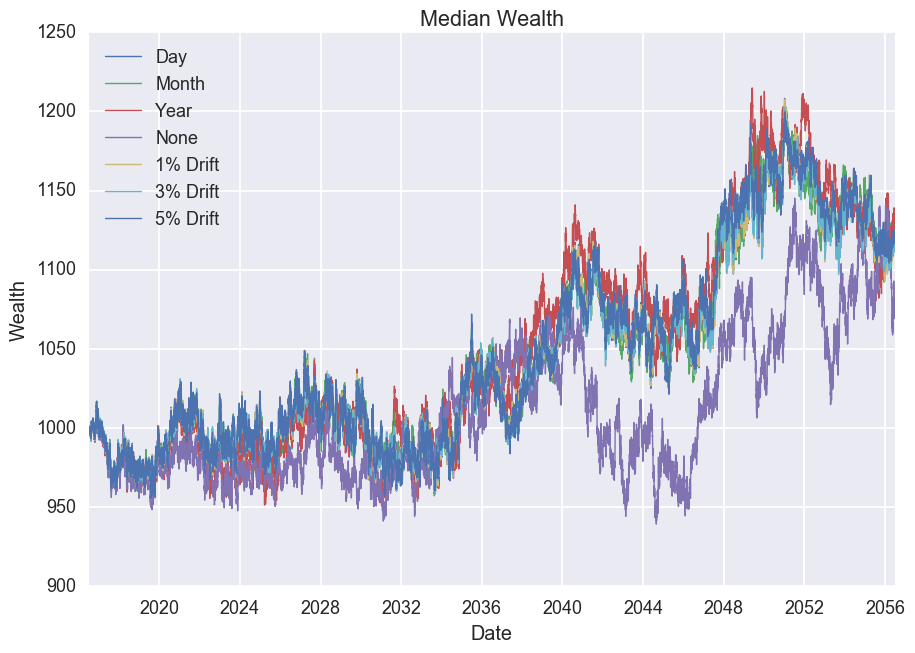

In [45]:
#print results: Wealth (median)
plt.figure(1)
plt.plot(Wmed.index,Wmed.values)
plt.xlabel('Date')
plt.ylabel('Wealth')
plt.title('Median Wealth')
plt.legend(['Day', 'Month', 'Year','None', '1% Drift', '3% Drift', '5% Drift'], loc = 0)
print('Median Wealth after 40 Years \nDaily Rebalancing: ${0:.2f} \nMonthly Rebalancing: ${1:.2f} \nYearly Rebalancing: ${2:.2f} \nNo Rebalancing: ${3:.2f} \n1% Drift: ${4:.2f} \n3% Drift: ${5:.2f} \n5% Drift: ${6:.2f}'.
      format(Wmed.iloc[len(Wmed.index)-1][0], Wmed.iloc[len(Wmed.index)-1][1], Wmed.iloc[len(Wmed.index)-1][2], Wmed.iloc[len(Wmed.index)-1][3], Wmed.iloc[len(Wmed.index)-1][4], Wmed.iloc[len(Wmed.index)-1][5], Wmed.iloc[len(Wmed.index)-1][6]))

Mean Wealth[95% confidence interval] 
Daily Rebalancing: $1243.28 +/- 1352.18 
Monthly Rebalancing: $1241.81 +/- 1346.40 
Yearly Rebalancing: $1246.07 +/- 1398.49 
No Rebalancing: $1198.40 +/- 1366.51 
1% Drift: $1242.82 +/- 1349.55 
3% Drift: $1242.11 +/- 1344.85 
5% Drift: $1243.92 +/- 1343.61


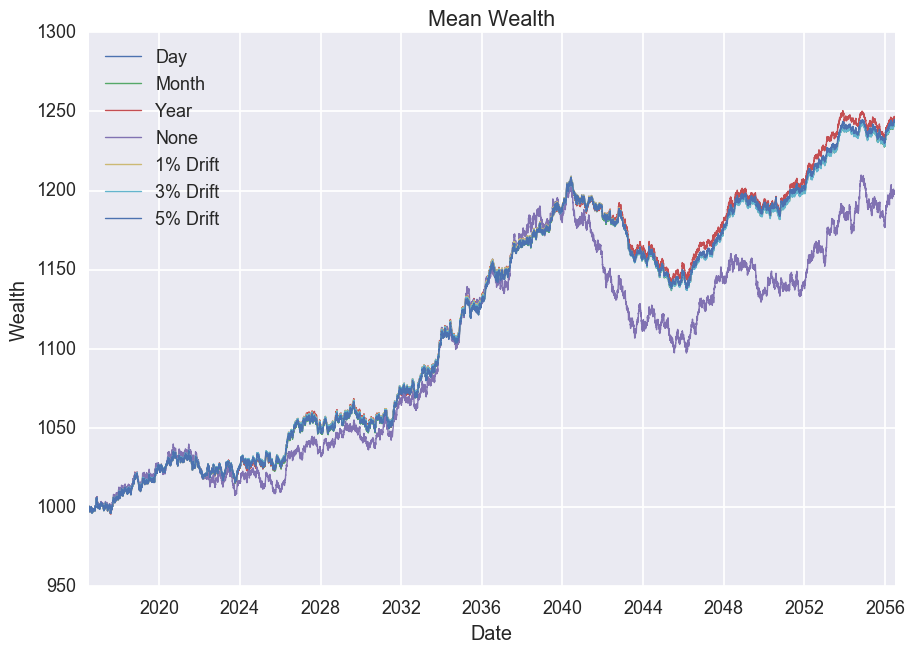

In [46]:
#print results: Wealth (mean)
plt.figure(1)
plt.plot(Wavg.index,Wavg.values)
plt.xlabel('Date')
plt.ylabel('Wealth')
plt.title('Mean Wealth')
plt.legend(['Day', 'Month', 'Year','None', '1% Drift', '3% Drift', '5% Drift'], loc = 0)
print('Mean Wealth[95% confidence interval] \nDaily Rebalancing: ${0:.2f} +/- {7:.2f} \nMonthly Rebalancing: ${1:.2f} +/- {8:.2f} \nYearly Rebalancing: ${2:.2f} +/- {9:.2f} \nNo Rebalancing: ${3:.2f} +/- {10:.2f} \n1% Drift: ${4:.2f} +/- {11:.2f} \n3% Drift: ${5:.2f} +/- {12:.2f} \n5% Drift: ${6:.2f} +/- {13:.2f}'.
      format(Wavg.iloc[len(Wavg.index)-1][0], Wavg.iloc[len(Wavg.index)-1][1], Wavg.iloc[len(Wavg.index)-1][2], Wavg.iloc[len(Wavg.index)-1][3], Wavg.iloc[len(Wavg.index)-1][4], Wavg.iloc[len(Wavg.index)-1][5], Wavg.iloc[len(Wavg.index)-1][6],Wstdf[0],Wstdf[1],Wstdf[2],Wstdf[3],Wstdf[4],Wstdf[5],Wstdf[6]))

In [47]:
for k in range(0,len(Wavg.columns)):

    # create a time-series of monthly data points
    rsmp = Wavg.resample('M').last()

    # compute returns
    rts = rsmp/rsmp.shift(1) - 1
    rts = rts.dropna()    
    av_ret = rts.mean()

Average Return 
Daily Rebalancing: 0.000461% 
Monthly Rebalancing: 0.000459% 
Yearly Rebalancing: 0.000466% 
No Rebalancing: 0.000388% 
1% Drift: 0.000460% 
3% Drift: 0.000459% 
5% Drift: 0.000462%


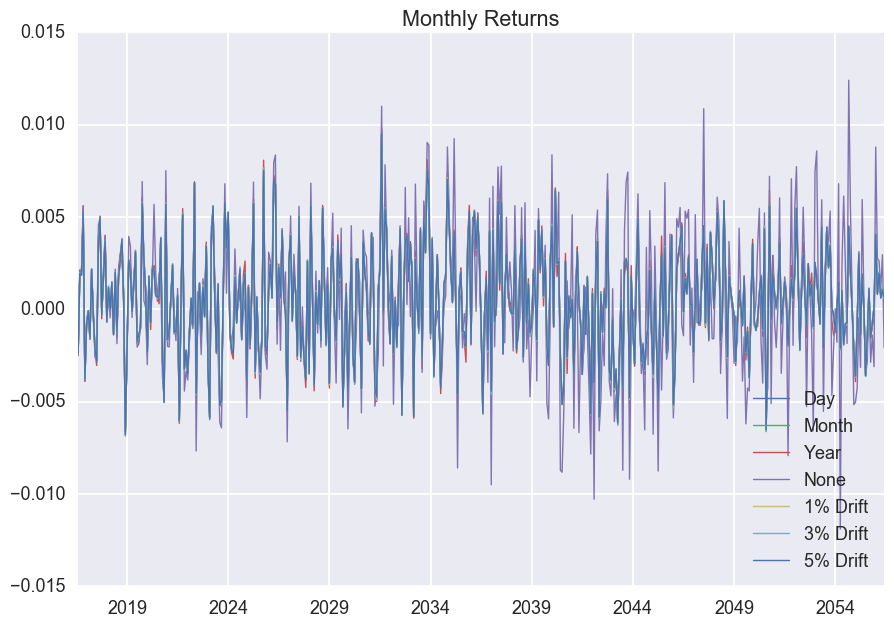

In [48]:
#print results: returns
print('Average Return \nDaily Rebalancing: {0:.6f}% \nMonthly Rebalancing: {1:.6f}% \nYearly Rebalancing: {2:.6f}% \nNo Rebalancing: {3:.6f}% \n1% Drift: {4:.6f}% \n3% Drift: {5:.6f}% \n5% Drift: {6:.6f}%'.
      format(av_ret[0], av_ret[1], av_ret[2],av_ret[3], av_ret[4], av_ret[5], av_ret[6]))
rts.plot()
plt.title('Monthly Returns')
plt.legend(['Day', 'Month', 'Year','None', '1% Drift', '3% Drift', '5% Drift'], loc = 0)

Average Volatility 
Daily Rebalancing: 0.3022% +/- 0.4920 
Monthly Rebalancing: 0.3028% +/- 0.4952 
Yearly Rebalancing: 0.3101% +/- 0.5163 
No Rebalancing: 0.7382% +/- 3.1002 
1% Drift: 0.3022% +/- 0.4927 
3% Drift: 0.3023% +/- 0.4986 
5% Drift: 0.3025% +/- 0.5013


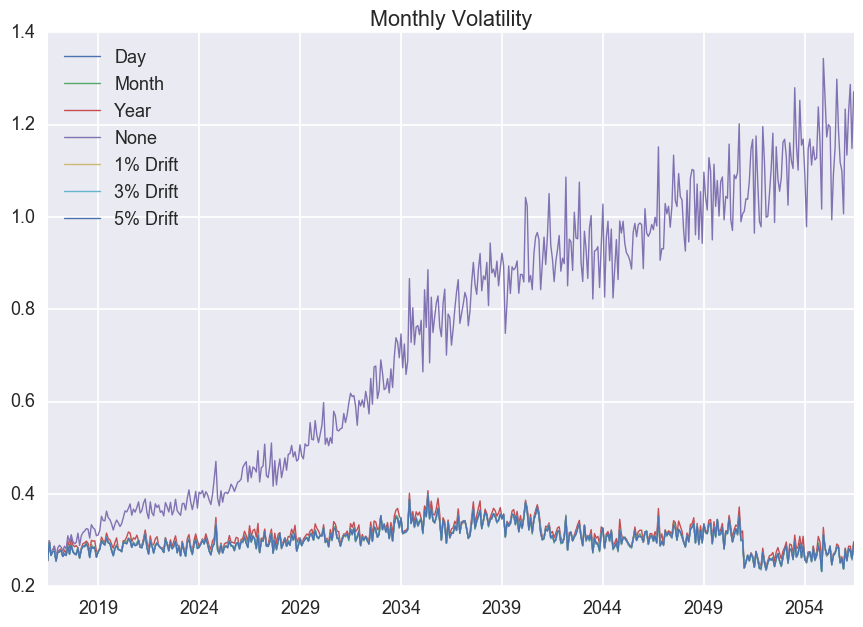

In [49]:
volavg = volsim.mean(axis=0)
volstd = volsim.std(axis=0)
volstdf = volstd.iloc[len(volstd.index)-1]
volstdf = volstdf.values
tval = stats.norm.ppf(1-(1-0.95)/2) #calculated 2-tailed critical t value
volstdf = volstdf*tval

#print results: volatility
volavg_rsmp = volavg.resample('M').last()
av_vol = volavg.mean()

print('Average Volatility \nDaily Rebalancing: {0:.4f}% +/- {7:.4f} \nMonthly Rebalancing: {1:.4f}% +/- {8:.4f} \nYearly Rebalancing: {2:.4f}% +/- {9:.4f} \nNo Rebalancing: {3:.4f}% +/- {10:.4f} \n1% Drift: {4:.4f}% +/- {11:.4f} \n3% Drift: {5:.4f}% +/- {12:.4f} \n5% Drift: {6:.4f}% +/- {13:.4f}'.
      format(av_vol[0], av_vol[1], av_vol[2],av_vol[3], av_vol[4], av_vol[5], av_vol[6], volstdf[0], volstdf[1], volstdf[2],volstdf[3],volstdf[4],volstdf[5],volstdf[6]))
volavg_rsmp.plot()
plt.title('Monthly Volatility')
plt.legend(['Day', 'Month', 'Year','None', '1% Drift', '3% Drift', '5% Drift'], loc = 0)
#plt.axhline(y=0.07/12, color='k', linestyle='-') #compare to a target annual return of 7%

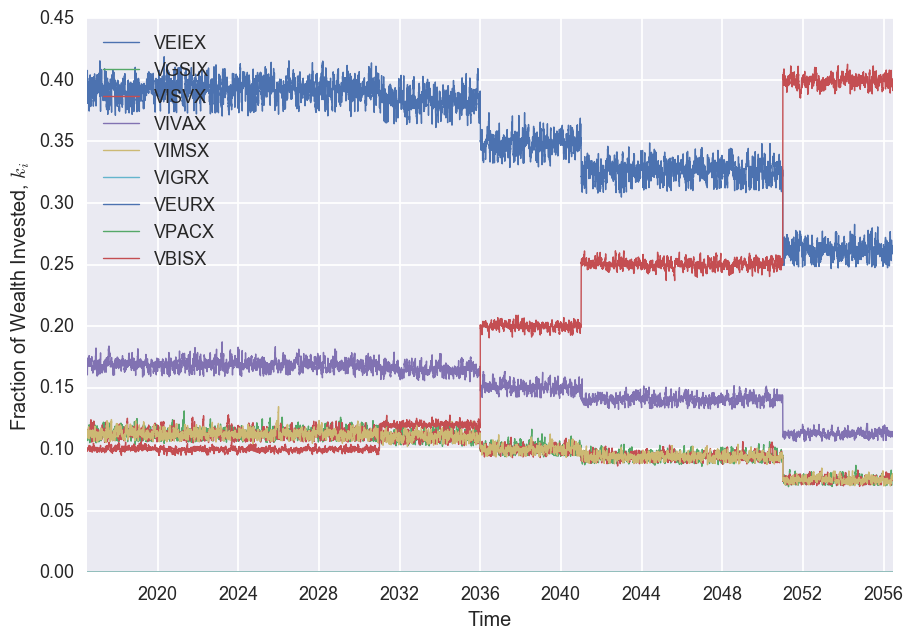

In [57]:
#view change in allocation over time
plt.plot(Psim[0].index.values,kmat)
kmat.sum(axis=1)
plt.xlabel('Time')
plt.ylabel('Fraction of Wealth Invested, $k_i$')
plt.legend(fundnames, loc=0)

## References

### Paper
See paper [here](https://docs.google.com/document/d/1fpUANto48Iq5Xu4GuVfPSoU0yn8855vRTDHFL--zANw/edit?usp=sharing); academic resources at end of paper.

### Code
* [Simpy example by Jeffrey Kantor](https://github.com/jckantor/ESTM60203/blob/master/notebooks/Getting%20Started%20with%20Discrete%20Event%20Simulation.ipynb)  
* Vanguard program by Tom Cosimano
* [Calculating Stock Beta, Volatility, and More by Gouthaman Balaraman](http://gouthamanbalaraman.com/blog/calculating-stock-beta.html)